In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from matplotlib_venn import venn3, venn3_unweighted
import venn

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def get_reverse(nucleotyde):
    nucleotyde = str(nucleotyde)
    nucleotyde_rev = {'A' : 'T',
                     'T' : 'A',
                     'C' : 'G',
                     'G': 'C'}
    if len(nucleotyde) > 1:
        nucleotyde_str = nucleotyde[::-1] #Reverse nucleotide
        nucleotyde_str_fin = "".join([nucleotyde_rev[x] for x in nucleotyde_str]) #Complement nucleotide
        return nucleotyde_str_fin
    else:
        return nucleotyde_rev[nucleotyde]

In [4]:
print(get_reverse('ATTGCCA'))

TGGCAAT


# Declare files

In [5]:
vcf_res = "MTB_Base_Calibration_List.vcf"
phyres = "201907/nph-phyresse_v29.xlsx"
#ptt = "../genes/H37Rv_annotation2sytems.ptt"
#megalist = "201907/Resistance_Report_v2019-01.xlsx"
#genbank = "../genes/Gene_list_from_genbank_v2.tsv"
#extended_res = "MTB_Extended_Resistance_Mediating.txt"


In [6]:
def extract_nuchange(row):
    if ">" in row.nuchange:
        nuchange_split = re.findall(r'(^[-]?\d*.*\d)([ATCG]+)>([ATCG]+)', row.nuchange)[0]
        if len(nuchange_split) == 3:
            return nuchange_split
        else:
            return ('Nan', 'NaN', 'NaN')

In [7]:
def extract_snp(row):
    if ">" in row.nuchange:
        return "snp" + ',' + "test"

In [8]:
#def import_megatable(megatable):
#    df = pd.read_excel(megatable, skiprows=1)
#    
#    df['tmp'] = df.apply(extract_nuchange, axis=1)
#    df = df[df.tmp.notnull()]
    #SPLIT TUPLES INTO COLUMNS!!!!!!!!!!
#    df[['gene_pos','REF', 'ALT']] = pd.DataFrame(df.tmp.values.tolist(), index= df.index)
#    df.drop('tmp', axis=1, inplace=True)
#    df[['Gene','is_upstream']]=df.gene.str.split(' ', expand=True)
#    df.gene_pos = df.gene_pos.astype(int)
    #df['tmp2'] = list(df.tmp).str.split(expand=True)
    #df[['gene_pos','REF', 'ALT']] = df.tmp.str[0:].str.split( expand=True)
    #df['stats'].str[1:-1].str.split(',', expand=True).astype(float)
#    return df

In [9]:
def import_phyres(phyres):
    df = pd.read_excel(phyres, sep='\t', header=0)
    
    df['REF']=df['WT base'].str.upper()
    df['ALT']=df['Var. base'].str.upper()
    df.rename(columns={'#Variant position genome start':'POS'}, inplace=True)
    df['High Confidence SNP'].fillna("no", inplace=True)
    #df['POSALT'] = df['POS'].astype(str) + df['ALT'] Not needed - Previous comparing
    #df = df[df['Var. type'] == 'SNP'] #Remove INDELS >> Do no remove INDELS
    df['Isreverse'] = df['Gene ID'].apply(lambda x: True if x.endswith("c") else False)
    
    
    return df

In [10]:
def import_VCF41_to_pandas(vcf_file):
    header_lines = 0
    with open(vcf_file) as f:
        first_line = f.readline().strip()
        next_line = f.readline().strip()
        while next_line.startswith("##"):
            header_lines = header_lines + 1
            #print(next_line)
            next_line = f.readline()

    if first_line.endswith('VCFv4.1'):
        df = pd.read_csv(vcf_file, sep='\t', skiprows=[header_lines], header=header_lines)
        
        for index, _ in df.iterrows():
            info_fields = re.findall(r';*([a-zA-Z]{1,20})=', df.loc[index,'INFO'])
            info_values = re.sub(r'([a-zA-Z]{1,20})=', '', df.loc[index,'INFO']).split(";") #Remove fields and split the remaining
        
            for ifield, ivalue in zip(info_fields,info_values):
                df.loc[index,ifield] = ivalue
        
        df = df[(~df['RES'].str.startswith("phylo"))] #Remove phylo(lineage) markers
        df['ALT']=df['ALT'].str.upper()
        df['REF']=df['REF'].str.upper()
        df[['Gene ID', 'Gene name', 'Gene start', 'Gene stop']] = df.GENE.str.split(":", expand=True)
        #df['GENE'] = df['INFO'].apply(lambda x: extract_gene_name(x))
        df['Isreverse'] = df['Gene ID'].apply(lambda x: True if x.endswith("c") else False)
        
        #df['POSALT'] = df['POS'].astype(str) + df['ALT'] Not needed - Previous comparing
        
        return df
    else:
        print("This vcf file is not v4.1")
        sys.exit(1)

# Import files

In [11]:
#mega_df = import_megatable(megalist)
#ptt_df = pd.read_csv(ptt, sep='\t', skiprows=2)
vcf_res_df = import_VCF41_to_pandas(vcf_res)
phyres_df = import_phyres(phyres)
#genbank_df = pd.read_csv(genbank, sep='\t', names=['Gene','Gene_id','start','end','strand'])

In [12]:
vcf_res_df.head(5)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,REG,SVTYPE,GENE,AMINO,RES,Gene ID,Gene name,Gene start,Gene stop,Isreverse
0,MTB_anc,6575,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485Cys,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False
1,MTB_anc,6576,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485His,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False
2,MTB_anc,6579,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Phe,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False
3,MTB_anc,6579,.,C,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Tyr,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False
4,MTB_anc,6620,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Asp500Asn,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False


In [13]:
phyres_df.head(5)

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,Gene stop,Gene length,Dir.,WT AA,Codon nr.,Codon nr. E. coli,Var. AA,AA change,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,REF,ALT,Isreverse
0,6575,6575,SNP,1,c,t,coding,Rv0005,gyrB,5240,7267,2028,+,Arg,446,-,Cys,Arg446Cys,cgt/tgt,1336,1336,fluoroquinolones (FQ),19470506,no,C,T,False
1,6620,6620,SNP,1,g,c,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,His,Asp461His,gac/cac,1381,1381,fluoroquinolones (FQ),24055765,yes,G,C,False
2,6620,6620,SNP,1,g,a,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,Asn,Asp461Asn,gac/aac,1381,1381,fluoroquinolones (FQ),19721073,yes,G,A,False
3,6621,6621,SNP,1,a,c,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,Ala,Asp461Ala,gac/gcc,1382,1382,fluoroquinolones (FQ),24055765,yes,A,C,False
4,6734,6734,SNP,1,a,g,coding,Rv0005,gyrB,5240,7267,2028,+,Asn,499,-,Asp,Asn499Asp,aac/gac,1495,1495,fluoroquinolones (FQ),17412727,yes,A,G,False


## Check common positions within 2 Resistance datasets

In [31]:
V = set(vcf_res_df.POS.tolist())
P = set(phyres_df.POS.tolist())

In [32]:
print("additional vcf %s, and phyres %s" % (len(V), len(P)))

additional vcf 225, and phyres 539


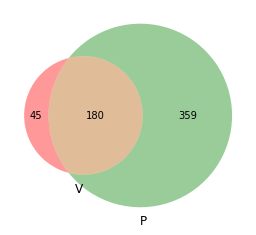

In [33]:
v = venn2([V, P], set_labels = ('V', 'P'), )

/home/laura/env36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/home/laura/env36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 720x360 with 0 Axes>

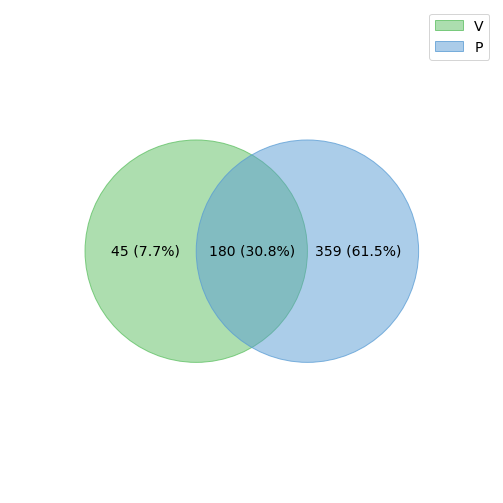

In [34]:
plt.figure(figsize=(10,5))
alpha = 0.2

labels = venn.get_labels([V, P], fill=['number',  'percent'] ) #'logic',
fig, ax = venn.venn2(labels, names=['V', 'P'])
fig.show()

# Change Nucleotide if gene is reverse

## Apply reverse if Gene is reverse

In [14]:
for i in vcf_res_df.index:
    alt_nucleotyde = vcf_res_df.loc[i, "ALT"]
    if vcf_res_df.loc[i, "Isreverse"] == True:
        vcf_res_df.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
    elif vcf_res_df.loc[i, "Isreverse"] == False:
        vcf_res_df.loc[i,'ALT2'] = alt_nucleotyde
        
for i in phyres_df.index:
    alt_nucleotyde = phyres_df.loc[i, "ALT"]
    if phyres_df.loc[i, "Isreverse"] == True:
        phyres_df.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
    elif phyres_df.loc[i, "Isreverse"] == False:
        phyres_df.loc[i,'ALT2'] = alt_nucleotyde
        
#for i in ultra_df_og.index:
#    alt_nucleotyde = ultra_df_og.loc[i, "ALT"]
#    if ultra_df_og.loc[i, "Isreverse"] == True:
#        ultra_df_og.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
#    elif ultra_df_og.loc[i, "Isreverse"] == False:
#        ultra_df_og.loc[i,'ALT2'] = alt_nucleotyde

# CREATE DICTIONARY

In [93]:
vcf_res_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,REG,SVTYPE,GENE,AMINO,RES,Gene ID,Gene name,Gene start,Gene stop,Isreverse,ALT2
0,MTB_anc,6575,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485Cys,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,T
1,MTB_anc,6576,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485His,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,A
2,MTB_anc,6579,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Phe,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,T
3,MTB_anc,6579,.,C,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Tyr,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,A
4,MTB_anc,6620,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Asp500Asn,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,A


In [94]:
vcf_res_df[vcf_res_df.SVTYPE != 'SNP' ]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,REG,SVTYPE,GENE,AMINO,RES,Gene ID,Gene name,Gene start,Gene stop,Isreverse,ALT2


In [95]:
phyres_df.head()

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,...,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,REF,ALT,Isreverse,ALT2
0,6575,6575,SNP,1,c,t,coding,Rv0005,gyrB,5240,...,cgt/tgt,1336,1336,fluoroquinolones (FQ),19470506,no,C,T,False,T
1,6620,6620,SNP,1,g,c,coding,Rv0005,gyrB,5240,...,gac/cac,1381,1381,fluoroquinolones (FQ),24055765,yes,G,C,False,C
2,6620,6620,SNP,1,g,a,coding,Rv0005,gyrB,5240,...,gac/aac,1381,1381,fluoroquinolones (FQ),19721073,yes,G,A,False,A
3,6621,6621,SNP,1,a,c,coding,Rv0005,gyrB,5240,...,gac/gcc,1382,1382,fluoroquinolones (FQ),24055765,yes,A,C,False,C
4,6734,6734,SNP,1,a,g,coding,Rv0005,gyrB,5240,...,aac/gac,1495,1495,fluoroquinolones (FQ),17412727,yes,A,G,False,G


In [101]:
phyres_df[phyres_df.POS == 3296371]

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,...,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,REF,ALT,Isreverse,ALT2
436,3296371,-,Ins,7,g,gccgcggc,coding,Rv2947c,pks15,3297840,...,ggc/gggccgcggc,1470,1470,"phylo (not Euro-American, M. africanum, M. bov...",18578864,no,G,GCCGCGGC,True,GCCGCGGC


# Now create dictionary

In [96]:
list_res_position = []
dict_res_position_base = {}

for index in phyres_df.index:
    position = phyres_df.loc[index,'POS']
    nucleotide = phyres_df.loc[index,'ALT2']
    resistance = phyres_df.loc[index,'Antibiotic']
    if position in list_res_position:
        list_value_res = dict_res_position_base[position]
        if nucleotide not in list_value_res[1:]:
            list_value_res.append(nucleotide)
            dict_res_position_base[position] = list_value_res
    else:
        list_res_position.append(position)
        dict_res_position_base[position] = [resistance, nucleotide]

for index in vcf_res_df.index:
    position = vcf_res_df.loc[index,'POS']
    nucleotide = vcf_res_df.loc[index,'ALT2']
    resistance = vcf_res_df.loc[index,'RES']
    if position in list_res_position:
        list_value_res = dict_res_position_base[position]
        if nucleotide not in list_value_res[1:]:
            list_value_res.append(nucleotide)
            dict_res_position_base[position] = list_value_res
    else:
        list_res_position.append(position)
        dict_res_position_base[position] = [resistance, nucleotide]


In [97]:
print(dict_res_position_base)

{6575: ['fluoroquinolones (FQ)', 'T'], 6620: ['fluoroquinolones (FQ)', 'C', 'A'], 6621: ['fluoroquinolones (FQ)', 'C'], 6734: ['fluoroquinolones (FQ)', 'G', 'A'], 6735: ['fluoroquinolones (FQ)', 'C'], 6736: ['fluoroquinolones (FQ)', 'G'], 6737: ['fluoroquinolones (FQ)', 'C'], 6738: ['fluoroquinolones (FQ)', 'A', 'T'], 6741: ['fluoroquinolones (FQ)', 'T'], 6742: ['fluoroquinolones (FQ)', 'T'], 6749: ['fluoroquinolones (FQ)', 'A'], 6750: ['fluoroquinolones (FQ)', 'T'], 7563: ['fluoroquinolones (FQ)', 'T'], 7564: ['fluoroquinolones (FQ)', 'C'], 7566: ['fluoroquinolones (FQ)', 'A'], 7570: ['fluoroquinolones (FQ)', 'T'], 7572: ['fluoroquinolones (FQ)', 'C'], 7581: ['fluoroquinolones (FQ)', 'C', 'A', 'T'], 7582: ['fluoroquinolones (FQ)', 'G', 'C', 'T'], 575729: ['ethionamide (ETH)', 'T'], 576164: ['ethionamide (ETH)', 'T'], 576242: ['ethionamide (ETH)', 'T'], 576338: ['ethionamide (ETH)', 'T'], 576414: ['ethionamide (ETH)', 'A'], 576429: ['ethionamide (ETH)', 'C'], 760314: ['rifampicin (RMP)

## Save dictionary into a file and remove lineage positions

In [100]:
with open ('dict_position_resistance_v1.txt', 'w+') as f:
    for k, v in dict_res_position_base.items():
        if not v[0].startswith('phylo'):
            line = str(k).strip() + ":" + ",".join(v) + "\n"
            #print(line)
            f.write(line)
        

# Shorter dictionary for high confidence SNP (Needs to be updated)

In [15]:
dict_res_position_confidence = {}
for index in phyres_df.index:
    position = phyres_df.loc[index,'POS']
    nucleotide = phyres_df.loc[index,'ALT2']
    #'High Confidence SNP'

    if phyres_df.loc[index,'High Confidence SNP'] == "yes":
        dict_res_position_confidence[position] = nucleotide

In [23]:
list_res_position_confidence = []
dict_res_position_confidence = {}

for index in phyres_df.index:
    position = phyres_df.loc[index,'POS']
    nucleotide = phyres_df.loc[index,'ALT2']
    is_high_confidence = phyres_df.loc[index,'High Confidence SNP']
    if position in list_res_position_confidence:
        list_value_res_c = dict_res_position_confidence[position]
        if nucleotide not in list_value_res_c[1:]:
            list_value_res_c.append(nucleotide)
            dict_res_position_confidence[position] = list_value_res_c
    else:
        list_res_position_confidence.append(position)
        dict_res_position_confidence[position] = [is_high_confidence, nucleotide]

In [25]:
with open ('dict_position_resistance_high_conf.txt', 'w+') as f:
    for k, v in dict_res_position_confidence.items():
        if not v[0].startswith('phylo'):
            line = str(k).strip() + ":" + ",".join(v) + "\n"
            #print(line)
            f.write(line)

In [24]:
print(dict_res_position_confidence)

{6575: ['no', 'T'], 6620: ['yes', 'C', 'A'], 6621: ['yes', 'C'], 6734: ['yes', 'G'], 6735: ['yes', 'C'], 6736: ['yes', 'G'], 6737: ['yes', 'C'], 6738: ['yes', 'A'], 6741: ['yes', 'T'], 6742: ['yes', 'T'], 6749: ['no', 'A'], 6750: ['yes', 'T'], 7563: ['yes', 'T'], 7564: ['yes', 'C'], 7566: ['no', 'A'], 7570: ['yes', 'T'], 7572: ['yes', 'C'], 7581: ['yes', 'C', 'A', 'T'], 7582: ['yes', 'G', 'C', 'T'], 575729: ['no', 'T'], 576164: ['no', 'T'], 576242: ['no', 'T'], 576338: ['no', 'T'], 576414: ['no', 'A'], 576429: ['no', 'C'], 760314: ['yes', 'T'], 761004: ['no', 'G'], 761093: ['no', 'C'], 761095: ['no', 'C', 'G'], 761098: ['no', 'T', 'C'], 761100: ['no', 'A'], 761101: ['no', 'C', 'T'], 761108: ['no', 'T'], 761109: ['yes', 'T'], 761110: ['yes', 'G', 'T'], 761111: ['no', 'G'], 761117: ['no', 'C'], 761120: ['no', 'G'], 761128: ['no', 'T', 'G'], 761139: ['yes', 'A', 'G', 'T'], 761140: ['yes', 'C', 'G', 'T'], 761141: ['no', 'A'], 761154: ['no', 'G'], 761155: ['yes', 'G', 'T'], 761161: ['yes', 

In [19]:
phyres_df[phyres_df.POS== 2155168]

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,Gene stop,Gene length,Dir.,WT AA,Codon nr.,Codon nr. E. coli,Var. AA,AA change,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,REF,ALT,Isreverse,ALT2
106,2155168,2155168,SNP,1,g,c,coding,Rv1908c,katG,2156111,2153889,2223,-,Ser,315,-,Thr,Ser315Thr,agc/acc,944,944,isoniazid (INH),8878604,yes,G,C,True,G
107,2155168,2155168,SNP,1,g,a,coding,Rv1908c,katG,2156111,2153889,2223,-,Ser,315,-,Asn,Ser315Asn,agc/aac,944,944,isoniazid (INH),9210694,yes,G,A,True,T
108,2155168,2155168,SNP,1,g,t,coding,Rv1908c,katG,2156111,2153889,2223,-,Ser,315,-,Ile,Ser315Ile,agc/atc,944,944,isoniazid (INH),9210694,yes,G,T,True,A
